# Minimized Volume for Reactors in Series/ Minimizando volumen para reactores en serie

### Autor: Carlos Planelles ([CAChemE.org](http://CAChemE.org)) - Licencia: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)

#### Fuente original: [Nicholas R. Larson y contribución de John L. Falconer](http://demonstrations.wolfram.com/MinimizedVolumeForReactorsInSeries/)


Esta mostrará de forma gráfica la variación de volumen total de dos reactores en serie, tipo reactor continuo de tanque agitado (CSTR) y reactor de flujo pistón (PFR), con distintas configuraciones.

La reacción será A --> B la velocidad de reacción variará según sea de:

Primer orden: $ -r_A = kC_{A0}(1-X_A) $ 

Segundo orden: $ -r_A = kC_{A0}(1-X_A)^2 $ #codigo original

Segundo orden: $ -r_A = k(C_{A0}(1-X_A))^2 $ #lo que yo pienso

Langmuir–Hinshelwood: $ -r_A = \frac{kC_A}{(1+K_AC_A+K_BC_B)^2} $

Suponemos que la concentración de A es mucho mayor que la de B ($C_A>>C_B$), por tanto:

Langmuir–Hinshelwood: $ -r_A = \frac{kC_{A0}(1-X_A)}{(1+K_AC_{A0}(1-X_A))^2} $

El volumen se calcula:

$V_{CSTR} = \frac{F_{A0}(X_{OUT}-X_{IN})}{(-r_A)_{OUT}}$

$V_{PFR} = F_{A0}\int\frac{1}{-r_A}dX$


In [6]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt 
from IPython.html.widgets import interact
from scipy.integrate import quad

plt.style.use('bmh')

## Escribimos las clases de los dos tipos de reactores

In [7]:
class CSTR(object):
    
    def __init__(self, Xin, Xout, tipo_reaccion):
        
        self.Xin = Xin
        self.Xout = Xout
        self.tipo_reac = tipo_reaccion
        self.Ca0 = 2
        self.k = 1
        self.K_A = 1.2
        self.K_B = 0
        self.F0 = 1
        
        
    def velocidad_reac(self,X):
    
        v = 0
        
        if self.tipo_reac == 0:
            # orden1
            v = -self.k*self.Ca0*(1-X)

        elif self.tipo_reac == 1:
            #orden2
            # Ver si esta bien
            # v = -self.k*(self.Ca0*(1-X))**2 
            v = -self.k*self.Ca0*(1-X)**2 #codigo original

        elif self.tipo_reac == 2:
            #Langmuir–Hinshelwood
            a = -self.k*self.Ca0*(1-X)
            b = (1/2+self.K_A*self.Ca0*(1-X)+self.K_B*self.Ca0*X)**2
            v = a/b
        
        return v
        
    
    #pensar otro nombre a la funcion
    def representar(self,X):
        X = self.Xout*np.ones(len(X))
        return -self.F0/self.velocidad_reac(X)
    
    def volumen(self):
        return -self.F0/self.velocidad_reac(self.Xout)*(self.Xout-self.Xin)
        
            

In [8]:
class PFR(CSTR):
    
    def representar(self,X):
        return -self.F0/self.velocidad_reac(X)
    
    def volumen(self):
        
        def inv_velocidad(x):
            return 1/self.velocidad_reac(x)
        
        [a,_] = quad(inv_velocidad, self.Xin, self.Xout)
        return -self.F0*a
        

## Dibujamos la gráfica

In [13]:
def serie(reaccion, reactor_1, reactor_2, X1, X2):
    
    if reactor_1 == 0:
        reactor1 = CSTR(0,X1,reaccion)
    elif reactor_1 == 1:
        reactor1 = PFR(0,X1,reaccion)
        
    if reactor_2 == 0:
        reactor2 = CSTR(X1,X2,reaccion)
    elif reactor_2 == 1:
        reactor2 = PFR(X1,X2,reaccion)
        
    #representamos F0*dx/(-ra)
    n = 5000
   
    x = np.linspace(0,0.99,n)
    
    n1 = int(n/0.99*X1)
    n2 = int(n/0.99*X2)
    
    x1 = x[0:n1]
    x2 = x[n1:n2]
    
    
    #calculamos reaccion
    reactor = PFR(0,0.99,reaccion)
    y0 = reactor.representar(x)
    
    #calculamos el primer reactor
    y1 = reactor1.representar(x1)
  
    #calculamos el segundo reactor
    y2 = reactor2.representar(x2)
    
    #para que fill lo represente bien:
    y1[-1] = 0
    y1[0] = 0
    
    #evitar error
    if X2 > X1:
        y2[-1] = 0
        y2[0] = 0
    
    #dibujamos
    plt.figure(figsize=(12, 6))
    plt.plot(x,y0,'black')
    plt.fill(x1,y1)
    if X2 > X1:
        plt.fill(x2,y2)
    
    plt.ylim(0,10)
    
    plt.ylabel('F0/(-ra)')
    plt.xlabel('X')
    
    volume_reactor1 =  reactor1.volumen()
    volume_reactor2 =  reactor2.volumen()
    
    if volume_reactor2 < 0:
        volume_reactor2 = 0
    
    volume_total = volume_reactor1+volume_reactor2
    
    #Use 8 characters, give f decimal places
    reac1_string = "%8.2f" % volume_reactor1
    reac2_string = "%8.2f" % volume_reactor2
    volumetotal_string = "%8.2f" % volume_total
    
    # Adding these annotations to the graph
    
    plt.text(1.01, 0, #position (time, temperature)
             
             'Volumen del reactor 1: ' + reac1_string + \
             ' $ L $ \n'+ \
             
             'Volumen del reactor 2: ' + reac2_string + \
             ' $ L $ \n'+ \
             
             'Volumen total: ' + volumetotal_string + \
             ' $ L $ \n \n'+ \
             
             '- CAChemE.org')

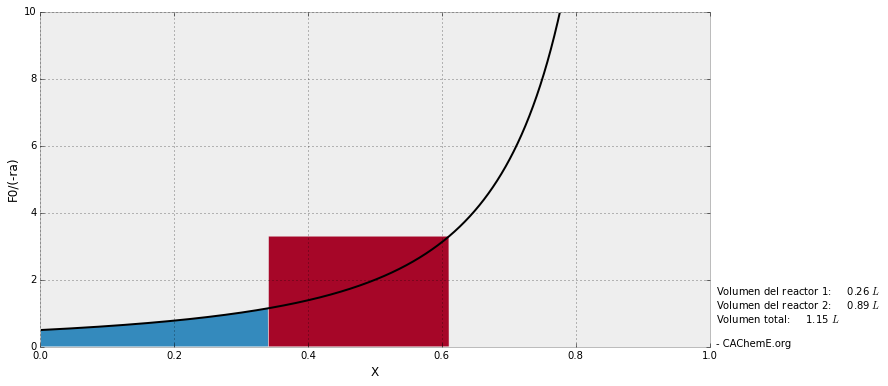

In [14]:
interact(serie,
         reaccion = {"Orden 1":0,"Orden 2":1, "Langmuir–Hinshelwood":2},
         reactor_1 = {"CSTR":0,"PFR":1},
         reactor_2 = {"CSTR":0,"PFR":1},
         X1 = (0.001,0.99,0.01),
         X2 = (0.001,0.99,0.01))